# 1. Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [27]:
df = pd.read_csv('../../data/input/input_dataset.csv')

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsScoredHA,GoalsConceded,GoalsConcededHA,GoalsDiff,GoalsDiffHA,HTGoalsScored,HTGoalsConceded,HTGoalsScoredHA,HTGoalsConcededHA,HTGoalsDiff,HTGoalsDiffHA,Points,PointsHA,WinPercent,WinPercentHA,WinStreak,UnbPercent,UnbPercentHA,UnbStreak,Def,Mid,Att,Ovr,WinnerOdd,DrawOdd,Venue,Result
0,P Dowd,Wed,0.0,-1,4.8,2.0,2.3,-2.2,-0.3,0.0,0.4,0.4,-0.4,-0.4,8.0,8.0,0.3,0.1,-0.1,-0.2,2.0,1.0,0.4,0.5,10.0,20.0,1.0,20.0,10.0,1.0,5,5,2,4.00,-7.10,4.5,Anfield,W
1,A Taylor,Sat,0.0,0,-1.0,-2.2,-0.6,0.6,0.3,0.1,-0.1,0.3,0.6,0.3,-7.0,0.0,-0.4,0.0,0.0,0.1,-4.0,-1.0,-0.5,0.0,-20.0,0.0,-1.0,-10.0,0.0,0.0,0,-5,-5,-3.33,-1.65,3.4,DW Stadium,L
2,L Mason,Sat,0.0,-1,-5.0,-4.3,-1.0,-0.1,0.3,0.0,-0.3,0.7,0.5,0.2,-8.0,5.0,-0.6,0.2,-0.2,0.2,-8.0,-4.0,-0.5,0.3,-20.0,0.0,0.0,-10.0,30.0,0.0,-4,-5,-4,-4.33,-0.50,3.4,Madejski Stadium,W
3,R East,Sat,0.0,0,2.0,0.1,0.9,-0.1,0.0,0.1,0.1,0.2,0.1,-0.6,0.0,8.0,-0.4,0.0,-0.2,-0.3,-4.0,1.0,-0.2,0.4,-10.0,10.0,1.0,0.0,20.0,1.0,-3,0,-3,-2.00,-1.95,3.5,The Hawthorns,W
4,M Jones,Sat,0.0,0,0.1,-1.0,-0.9,-0.7,0.1,0.0,-0.6,-0.6,-0.1,-0.4,-5.0,-2.0,-0.5,0.0,-0.6,0.0,-5.0,-6.0,-0.1,-0.2,-10.0,-20.0,1.0,10.0,20.0,0.0,0,-1,2,0.34,-1.25,3.4,Loftus Road,W


In [28]:
# label encode categorical feature- Day Of Week
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode categorical feature- Referee
referee_le = LabelEncoder()
df['Referee'] = referee_le.fit_transform(df['Referee'])

# label encode categorical feature- Venue
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

# 3. Feature Selection

In [29]:
selected_features = ['Round', 'Shots', 'ShotsOT', 'Corners', 'Fouls', 'GoalsScored', 'GoalsConceded', 'GoalsDiff', 'HTGoalsScored', 'HTGoalsDiff', 'Points', 'WinPercent', 'UnbPercent', 'Def', 'Mid', 'Att', 'Ovr', 'WinnerOdd', 'DrawOdd', 'Venue']

# 4. Model Building- Data Split 4

- Target Variable: Win/Lose/Draw
- Balanced Sampling

### LazyPredict

In [41]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Referee'] = referee_le.transform(X_train['Referee'])
# X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :-1] = wdl_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wdl_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
2    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


In [17]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.11it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.48,0.52,None,0.53,0.03
LogisticRegression,0.52,0.51,None,0.56,0.04
AdaBoostClassifier,0.52,0.51,None,0.55,0.17
CalibratedClassifierCV,0.53,0.51,None,0.57,1.41
GaussianNB,0.53,0.51,None,0.57,0.02
RidgeClassifier,0.52,0.51,None,0.56,0.02
RidgeClassifierCV,0.52,0.50,None,0.56,0.02
LinearSVC,0.52,0.50,None,0.56,0.35
ExtraTreesClassifier,0.52,0.49,None,0.56,0.34


### Random Forest Classifier

#### Fold 1

In [8]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
2    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


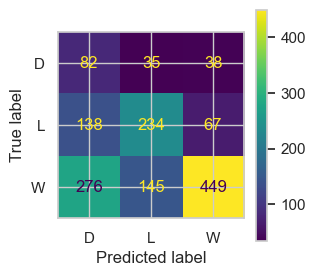

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [10]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5225409836065574
ROC score on Test Set: 0.7353952939662772

              precision    recall  f1-score   support

           0       0.17      0.53      0.25       155
           1       0.57      0.53      0.55       439
           2       0.81      0.52      0.63       870

    accuracy                           0.52      1464
   macro avg       0.51      0.53      0.48      1464
weighted avg       0.67      0.52      0.57      1464



#### Fold 2

In [12]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
2    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


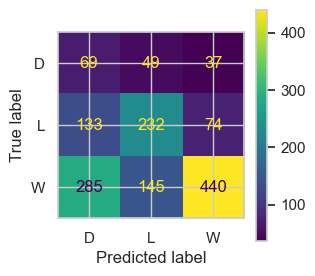

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5061475409836066
ROC score on Test Set: 0.7292610950225159

              precision    recall  f1-score   support

           0       0.14      0.45      0.21       155
           1       0.54      0.53      0.54       439
           2       0.80      0.51      0.62       870

    accuracy                           0.51      1464
   macro avg       0.49      0.49      0.46      1464
weighted avg       0.65      0.51      0.55      1464



#### Fold 3

In [16]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
2    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


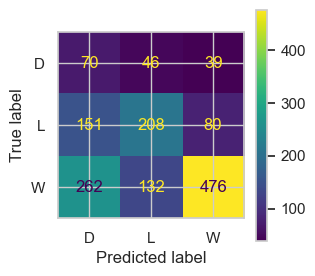

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5150273224043715
ROC score on Test Set: 0.7253755228001509

              precision    recall  f1-score   support

           0       0.14      0.45      0.22       155
           1       0.54      0.47      0.50       439
           2       0.80      0.55      0.65       870

    accuracy                           0.52      1464
   macro avg       0.49      0.49      0.46      1464
weighted avg       0.65      0.52      0.56      1464



#### Fold 4

In [19]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
2    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


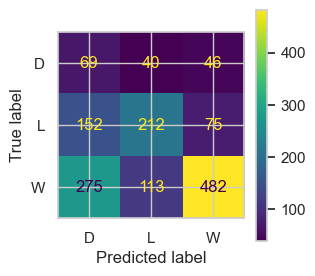

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [21]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5211748633879781
ROC score on Test Set: 0.7285608247717521

              precision    recall  f1-score   support

           0       0.14      0.45      0.21       155
           1       0.58      0.48      0.53       439
           2       0.80      0.55      0.65       870

    accuracy                           0.52      1464
   macro avg       0.51      0.49      0.46      1464
weighted avg       0.66      0.52      0.57      1464



#### Fold 5

In [22]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    620
2    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


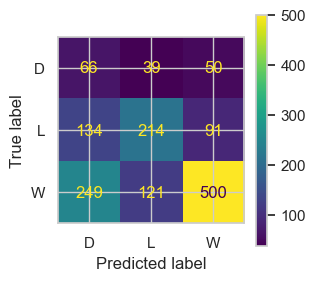

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5327868852459017
ROC score on Test Set: 0.7230650487355256

              precision    recall  f1-score   support

           0       0.15      0.43      0.22       155
           1       0.57      0.49      0.53       439
           2       0.78      0.57      0.66       870

    accuracy                           0.53      1464
   macro avg       0.50      0.50      0.47      1464
weighted avg       0.65      0.53      0.57      1464



### Logistic Regression

#### Fold 1

In [21]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0886, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


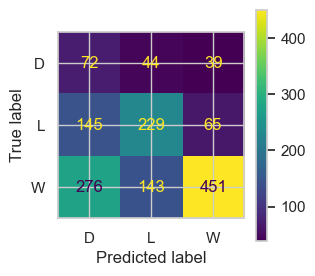

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5136612021857924
ROC score on Test Set: 0.7383766567315109

              precision    recall  f1-score   support

           0       0.15      0.46      0.22       155
           1       0.55      0.52      0.54       439
           2       0.81      0.52      0.63       870

    accuracy                           0.51      1464
   macro avg       0.50      0.50      0.46      1464
weighted avg       0.66      0.51      0.56      1464



#### Fold 2

In [24]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0886, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


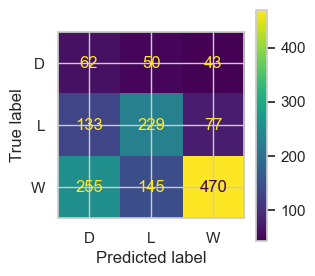

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.519808743169399
ROC score on Test Set: 0.7331004327088638

              precision    recall  f1-score   support

           0       0.14      0.40      0.20       155
           1       0.54      0.52      0.53       439
           2       0.80      0.54      0.64       870

    accuracy                           0.52      1464
   macro avg       0.49      0.49      0.46      1464
weighted avg       0.65      0.52      0.56      1464



#### Fold 3

In [27]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0886, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


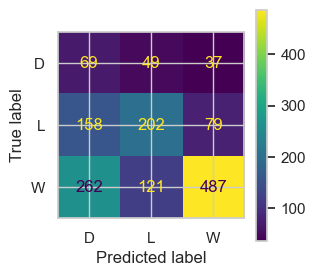

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.51775956284153
ROC score on Test Set: 0.7306318837091822

              precision    recall  f1-score   support

           0       0.14      0.45      0.21       155
           1       0.54      0.46      0.50       439
           2       0.81      0.56      0.66       870

    accuracy                           0.52      1464
   macro avg       0.50      0.49      0.46      1464
weighted avg       0.66      0.52      0.57      1464



#### Fold 4

In [30]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0886, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


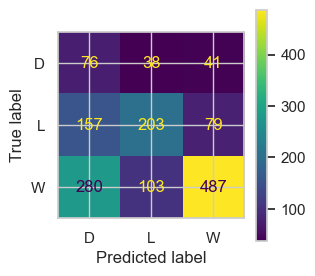

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.523224043715847
ROC score on Test Set: 0.7343466384207147

              precision    recall  f1-score   support

           0       0.15      0.49      0.23       155
           1       0.59      0.46      0.52       439
           2       0.80      0.56      0.66       870

    accuracy                           0.52      1464
   macro avg       0.51      0.50      0.47      1464
weighted avg       0.67      0.52      0.57      1464



#### Fold 5

In [33]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0886, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


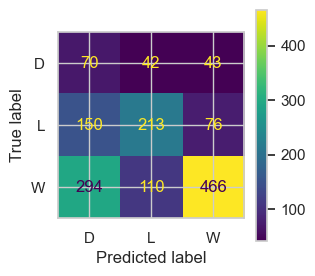

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [35]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5116120218579235
ROC score on Test Set: 0.7290802065370081

              precision    recall  f1-score   support

           0       0.14      0.45      0.21       155
           1       0.58      0.49      0.53       439
           2       0.80      0.54      0.64       870

    accuracy                           0.51      1464
   macro avg       0.51      0.49      0.46      1464
weighted avg       0.66      0.51      0.56      1464



### SVM Classifier

#### Fold 1

In [36]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


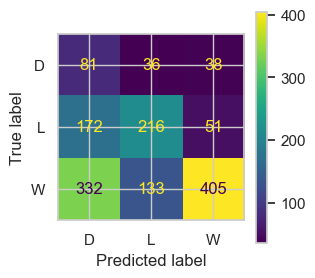

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.47950819672131145
ROC score on Test Set: 0.7212370606464146

              precision    recall  f1-score   support

           0       0.14      0.52      0.22       155
           1       0.56      0.49      0.52       439
           2       0.82      0.47      0.59       870

    accuracy                           0.48      1464
   macro avg       0.51      0.49      0.45      1464
weighted avg       0.67      0.48      0.53      1464



#### Fold 2

In [39]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


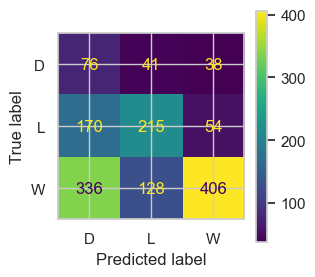

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4760928961748634
ROC score on Test Set: 0.7179812308541013

              precision    recall  f1-score   support

           0       0.13      0.49      0.21       155
           1       0.56      0.49      0.52       439
           2       0.82      0.47      0.59       870

    accuracy                           0.48      1464
   macro avg       0.50      0.48      0.44      1464
weighted avg       0.67      0.48      0.53      1464



#### Fold 3

In [42]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


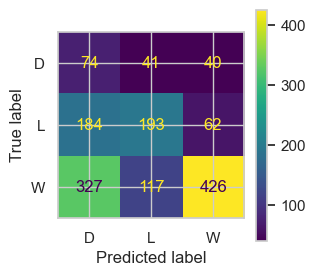

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.4733606557377049
ROC score on Test Set: 0.7127508500226276

              precision    recall  f1-score   support

           0       0.13      0.48      0.20       155
           1       0.55      0.44      0.49       439
           2       0.81      0.49      0.61       870

    accuracy                           0.47      1464
   macro avg       0.49      0.47      0.43      1464
weighted avg       0.66      0.47      0.53      1464



#### Fold 4

In [45]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


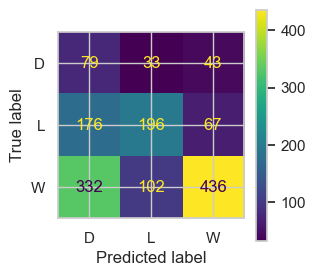

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [47]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.48565573770491804
ROC score on Test Set: 0.7198161452864081

              precision    recall  f1-score   support

           0       0.13      0.51      0.21       155
           1       0.59      0.45      0.51       439
           2       0.80      0.50      0.62       870

    accuracy                           0.49      1464
   macro avg       0.51      0.49      0.45      1464
weighted avg       0.67      0.49      0.54      1464



#### Fold 5

In [48]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


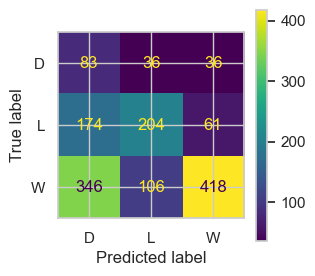

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [50]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.48155737704918034
ROC score on Test Set: 0.721274491212673

              precision    recall  f1-score   support

           0       0.14      0.54      0.22       155
           1       0.59      0.46      0.52       439
           2       0.81      0.48      0.60       870

    accuracy                           0.48      1464
   macro avg       0.51      0.49      0.45      1464
weighted avg       0.67      0.48      0.54      1464



### XGBoost Classifier

#### Fold 1

In [51]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


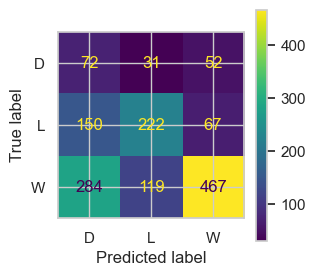

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.519808743169399
ROC score on Test Set: 0.7306899997736995

              precision    recall  f1-score   support

           0       0.14      0.46      0.22       155
           1       0.60      0.51      0.55       439
           2       0.80      0.54      0.64       870

    accuracy                           0.52      1464
   macro avg       0.51      0.50      0.47      1464
weighted avg       0.67      0.52      0.57      1464



#### Fold 2

In [54]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


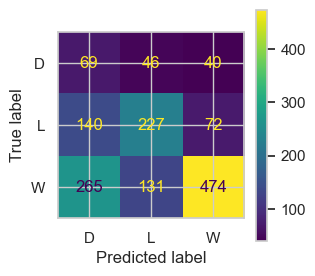

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5259562841530054
ROC score on Test Set: 0.7255986021543621

              precision    recall  f1-score   support

           0       0.15      0.45      0.22       155
           1       0.56      0.52      0.54       439
           2       0.81      0.54      0.65       870

    accuracy                           0.53      1464
   macro avg       0.51      0.50      0.47      1464
weighted avg       0.66      0.53      0.57      1464



#### Fold 3

In [57]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


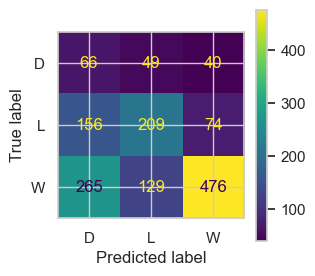

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5129781420765027
ROC score on Test Set: 0.7202197267260654

              precision    recall  f1-score   support

           0       0.14      0.43      0.21       155
           1       0.54      0.48      0.51       439
           2       0.81      0.55      0.65       870

    accuracy                           0.51      1464
   macro avg       0.49      0.48      0.45      1464
weighted avg       0.66      0.51      0.56      1464



#### Fold 4

In [60]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


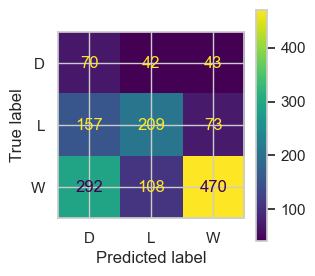

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5116120218579235
ROC score on Test Set: 0.7245703802201499

              precision    recall  f1-score   support

           0       0.13      0.45      0.21       155
           1       0.58      0.48      0.52       439
           2       0.80      0.54      0.65       870

    accuracy                           0.51      1464
   macro avg       0.51      0.49      0.46      1464
weighted avg       0.67      0.51      0.56      1464



#### Fold 5

In [63]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
# X_train['Venue'] = venue_le.transform(X_train['Venue'])
# X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    620
0    620
1    620
Name: Result, dtype: int64
2    870
1    439
0    155
Name: Result, dtype: int64


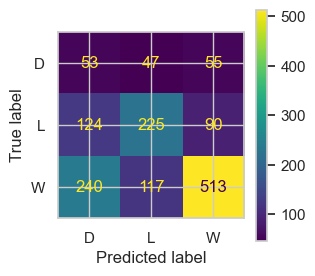

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [65]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5403005464480874
ROC score on Test Set: 0.72625166673562

              precision    recall  f1-score   support

           0       0.13      0.34      0.19       155
           1       0.58      0.51      0.54       439
           2       0.78      0.59      0.67       870

    accuracy                           0.54      1464
   macro avg       0.50      0.48      0.47      1464
weighted avg       0.65      0.54      0.58      1464

